# Example 2 - Improved Neural Network

This builds on Example 1 by using:

* Cross entropy cost
* L2 regularization
* Improved random weight initializaiton

In [1]:
import gzip
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random

%matplotlib inline
matplotlib.rc('font', family='Arial')

Helper functions. The `onehot()` function is new in example #2. The others are unchanged from example #1.

In [2]:
def load_data():
    with gzip.open('./mnist.pkl.gz') as mnist_file:
        train, validation, test = pickle.load(mnist_file, encoding='bytes')
    
    train_inputs = [np.reshape(x, (784, 1)) for x in train[0]]
    train_results = [one_hot(10, y) for y in train[1]]
    train_data = list(zip(train_inputs, train_results))
    
    validation_inputs = [np.reshape(x, (784, 1)) for x in validation[0]]
    validation_data = list(zip(validation_inputs, validation[1]))
    
    test_inputs = [np.reshape(x, (784, 1)) for x in test[0]]
    test_data = list(zip(test_inputs, test[1]))
    
    return train_data, validation_data, test_data

def one_hot(len_, j):
    vec = np.zeros((len_, 1))
    vec[j] = 1
    return vec
    
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    sz = sigmoid(z)
    return sz * (1 - sz)

The Network class has been modified from example 1:

* Keeps track of training & test accuracy by epoch.
* Implements improved initialization of random weights.
* Implements L2 regularization.

In [8]:
class Network:
    def __init__(self, sizes, activation_fn, activation_prime_fn, cost):
        self.activation_fn = activation_fn
        self.activation_prime_fn = activation_prime_fn
        self.cost = cost
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) / np.sqrt(x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def accuracy(self, data, convert=False):
        '''
        The ``convert`` flag is used to handle different representations
        of the ``y`` variable in the training and test/evaluation datasets.
        The flag should be set ``True`` when handling test/eval.
        '''
        results = list()
        
        if convert:
            for (x, y) in data:
                results.append(
                    (np.argmax(self.feedforward(x)), np.argmax(y))
                )
        else:
            for (x, y) in data:
                results.append(
                    (np.argmax(self.feedforward(x)), y)
                )
        
        return sum(int(x == y) for (x, y) in results)
        
    def backprop(self, x, y):
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]

        # Feed forward
        activation = x
        activations = [x]
        weighted_inputs = []

        for bias, weight in zip(self.biases, self.weights):
            weighted_input = np.dot(weight, activation) + bias
            weighted_inputs.append(weighted_input)
            activation = self.activation_fn(weighted_input)
            activations.append(activation)
        
        # Propagate backward
        partials = self.activation_prime_fn(weighted_inputs[-1])
        delta = self.cost.delta(partials, activations[-1], y)
        grad_b[-1] = delta
        grad_w[-1] = np.dot(delta, activations[-2].transpose())
        
        for layer in range(2, self.num_layers):
            partials = self.activation_prime_fn(weighted_inputs[-layer])
            delta = np.dot(self.weights[-layer+1].transpose(), delta) * partials
            grad_b[-layer] = delta
            grad_w[-layer] = np.dot(delta, activations[-layer  - 1].transpose())

        return grad_b, grad_w

    def cost_derivative(self, output_activations, y):
        return output_activations - y

    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y) 
                        for x, y in test_data]
        return sum(int(x == y) for x, y in test_results)

    def feedforward(self, x):
        activation = x
        for bias, weight in zip(self.biases, self.weights):
            activation = self.activation_fn(
                np.dot(weight, activation) + bias)
        return activation

    def sgd(self, train_data, epochs, mini_batch_size, 
            regularization, learning_rate, eval_data):
        train_size = len(train_data)
        eval_size = len(eval_data)

        train_cost = list()
        train_accuracy = list()
        eval_cost = list()
        eval_accuracy = list()
            
        for epoch in range(epochs):
            random.shuffle(train_data)
            mini_batches = [train_data[k:k+mini_batch_size] for k 
                            in range(0, train_size, mini_batch_size)]
            
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, learning_rate, regularization, train_size)
            
            print('Epoch {} training complete'.format(epoch))
            
            train_cost.append(
                self.total_cost(train_data, regularization))
            train_accuracy.append(
                self.accuracy(train_data, convert=True) / train_size)
            eval_cost.append(
                self.total_cost(eval_data, regularization, convert=True))
            eval_accuracy.append(
                self.accuracy(eval_data) / eval_size)
            
            print('Train cost: {:.3f}\taccuracy: {:0.3f}\n'
                  ' Test cost: {:.3f}\taccuracy: {:0.3f}\n'.format(
                train_cost[-1], train_accuracy[-1],
                eval_cost[-1], eval_accuracy[-1]))
            
        return train_cost, train_accuracy, eval_cost, eval_accuracy

    def total_cost(self, data, regularization, convert=False):
        '''
        Set ``convert`` flag to ``True`` for test/eval. Similar to 
        the flag on ``accuracy()`` but this one has inverse meaning.
        '''
        cost = 0
        size = len(data)
        
        for x, y in data:
            activation = self.feedforward(x)
            if convert:
                y = one_hot(self.sizes[-1], y)
            cost += self.cost.fn(activation, y) / size
        
        # Add L2 regularization term.
        sum_ = sum(np.linalg.norm(w) ** 2 for w in self.weights)
        cost += 0.5 * (regularization / size) * sum_
        
        return cost

    def update_mini_batch(self, mini_batch, learning_rate, 
                          regularization, size):
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        
        for x, y in mini_batch:
            delta_b, delta_w = self.backprop(x, y)
            grad_b = [gb + db for gb, db in zip(grad_b, delta_b)]
            grad_w = [gw + dw for gw, dw in zip(grad_w, delta_w)]
        
        new_biases = list()
        new_weights = list()
        
        for b, gb in zip(self.biases, grad_b):
            new_biases.append(b - (learning_rate/len(mini_batch)) * gb)

        for w, gw in zip(self.weights, grad_w):
            new_weights.append(
                (1 - learning_rate*(regularization/size)) * w - 
                (learning_rate/len(mini_batch)) * gw
            )
        
        self.biases = new_biases
        self.weights = new_weights

The cost function has been changed from example 1 to implement cross entropy instead of quadratic cost. It still conforms to the same interface, however.

In [4]:
class CrossEntropyCost:
    def fn(self, activations, y):
        return np.sum(np.nan_to_num(
            -y*np.log(activations) - (1-y) * np.log(1-activations)
        ))

    def delta(self, partials, activations, y):
        return (activations-y)

Load data (same as example #1).

In [5]:
train_data, validation_data, test_data = load_data()

Train a network. The performance of each epoch (measured by test examples correctly labeled) is displayed as the networks trains. This step takes about 5-10 minutes on my laptop.

In [9]:
net = Network(sizes=(784, 30, 10), 
              activation_fn=sigmoid,
              activation_prime_fn=sigmoid_prime,
              cost=CrossEntropyCost())

result = net.sgd(train_data, epochs=30, mini_batch_size=10, 
                 learning_rate=0.5, regularization=5, eval_data=test_data)

train_cost, train_accuracy, test_cost, test_accuracy = result

Epoch 0 training complete
Train cost: 0.471	accuracy: 0.942
 Test cost: 0.780	accuracy: 0.940

Epoch 1 training complete
Train cost: 0.458	accuracy: 0.946
 Test cost: 0.863	accuracy: 0.943

Epoch 2 training complete
Train cost: 0.422	accuracy: 0.955
 Test cost: 0.876	accuracy: 0.951

Epoch 3 training complete
Train cost: 0.396	accuracy: 0.959
 Test cost: 0.882	accuracy: 0.957

Epoch 4 training complete
Train cost: 0.408	accuracy: 0.960
 Test cost: 0.907	accuracy: 0.955

Epoch 5 training complete
Train cost: 0.413	accuracy: 0.959
 Test cost: 0.932	accuracy: 0.954

Epoch 6 training complete
Train cost: 0.408	accuracy: 0.963
 Test cost: 0.938	accuracy: 0.955

Epoch 7 training complete
Train cost: 0.426	accuracy: 0.960
 Test cost: 0.971	accuracy: 0.953

Epoch 8 training complete
Train cost: 0.421	accuracy: 0.960
 Test cost: 0.967	accuracy: 0.952

Epoch 9 training complete
Train cost: 0.420	accuracy: 0.959
 Test cost: 0.974	accuracy: 0.951

Epoch 10 training complete
Train cost: 0.395	accur

Show some randomly selected digits from the test set and use the neural network to predict the label. (Execute this cell again to pick a new set of random examples.) The actual label `y` and predicted label `ŷ` are shown above each example.

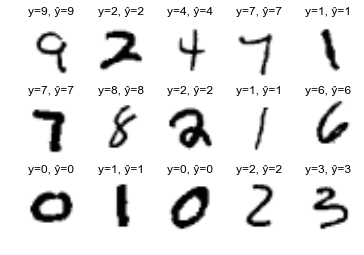

In [10]:
rows, cols = 3, 5

for i, (x, y) in enumerate(random.sample(test_data, rows * cols)):
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(np.reshape(x, (28,28)), cmap='Greys')
    y_hat = np.argmax(net.feedforward(x))
    plt.title('y={}, ŷ={}'.format(y, y_hat))

Plot performance against training epochs.

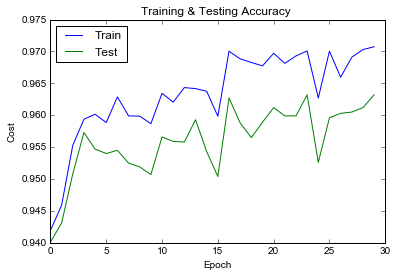

In [11]:
plt.plot(range(30), train_accuracy, label='Train')
plt.plot(range(30), test_accuracy, label='Test')
plt.title('Training & Testing Accuracy ')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend(loc='upper left')
plt.show()

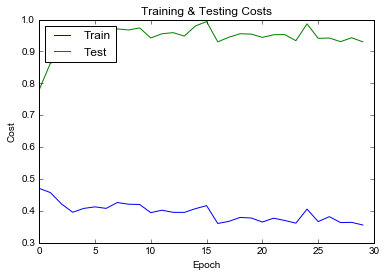

In [13]:
plt.plot(range(30), train_cost, label='Train')
plt.plot(range(30), test_cost, label='Test')
plt.title('Training & Testing Costs')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend(loc='upper left')
plt.show()

Visualize weights in an untrained network's hidden layer.

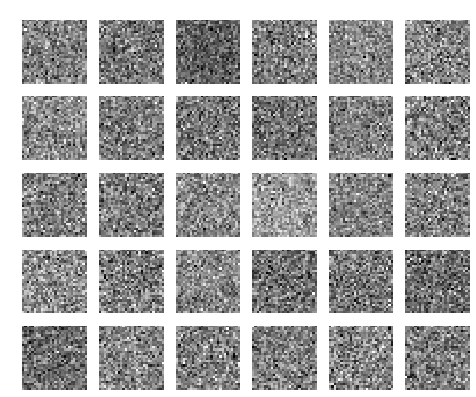

In [64]:
untrained  = Network(sizes=(784, 30, 10), 
                     activation_fn=sigmoid,
                     activation_prime_fn=sigmoid_prime,
                     cost=CrossEntropyCost())
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)

for neuron in range(30):
    sub = fig.add_subplot(6, 6, neuron + 1)
    sub.axis('off')
    sub.matshow(np.reshape(untrained.weights[0][neuron], (28,28)), 
                cmap='gray')

plt.show()

Now compare to the weights in the trained network's hidden layer.

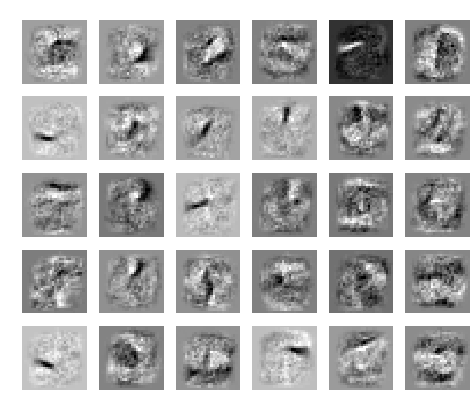

In [63]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)

for neuron in range(30):
    sub = fig.add_subplot(6, 6, neuron + 1)
    sub.axis('off')
    sub.matshow(np.reshape(net.weights[0][neuron], (28,28)), 
                cmap='gray')

plt.show()